In [34]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from utils import plot_confusion_matrix, plot_confusion_matrix, get_gzipped_model_size, rescale_data
from data_organizer_Kfall import DataOrganizer
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras import models, optimizers, callbacks
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from models.ConvLSTM import ConvLSTM
from models.ConvLSTM_VGG import ConvLSTM_VGG
from models.TinyFallNet import TinyFallNet
from models.ResNet24 import ResNet24
import matplotlib.pyplot as plt
import yaml

# Data Config

In [59]:
with open('./config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# mac
# data_path = config['data_path_mac']
# sensor_data_folder = os.path.join(data_path, 'sensor_data')
# label_data_folder = os.path.join(data_path, 'label_data')

# windows
data_path = config['data_path_win']
sensor_data_folder = os.path.join(data_path, 'sensor_data')
label_data_folder = os.path.join(data_path, 'label_data')

# linux
# data_path = config['data_path_linux']
# sensor_data_folder = os.path.join(data_path, 'sensor_data')
# label_data_folder = os.path.join(data_path, 'label_data')

# data mode. Combination of sensor data.
data_mode = 'ACC+GYRO' # 'ACC' or 'ACC+GYRO' or 'ACC+GYRO+MAG'
window_size = config['window_size'] # window size
fall_threshold = config['fall_threshold'] # threshold for windows labeled as fall
num_window_fall_data = config['num_window_fall_data']   # number of windows labeled as fall
num_window_not_fall_data = config['num_window_not_fall_data']    # number of windows labeled as not fall
acc_max = config['acc_max'] 
gyro_max = config['gyro_max'] 

# Model Config

In [52]:
model_name = "TinyFallNet_6axis_8bitInput" # "ConvLSTM" or "ConvLSTM_VGG" or "TinyFallNet" or "ResNet24" or "TinyFallNet_6axis"
load_from_checkpoint = config['load_from_checkpoint']

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

if load_from_checkpoint:
    model = models.load_model('./saved_models/'+model_name+'.keras')
else:
    if model_name == "ConvLSTM":
        model = ConvLSTM()
        data_mode = 'ACC+GYRO+MAG' # 'ACC' or 'ACC+GYRO' or 'ACC+GYRO+MAG'
    elif model_name == "ConvLSTM_VGG":
        model = ConvLSTM_VGG()
        data_mode = 'ACC+GYRO+MAG'
    elif model_name == "TinyFallNet":
        model = TinyFallNet()
        data_mode = 'ACC+GYRO+MAG'
    elif model_name == "ResNet24":
        model = ResNet24()
        data_mode = 'ACC+GYRO+MAG'
    elif model_name == "TinyFallNet_6axis":
        model = TinyFallNet(6)
        data_mode = 'ACC+GYRO'
    elif model_name == "TinyFallNet_6axis_8bitInput":
        model = TinyFallNet(6)
        data_mode = 'ACC+GYRO'
    else:
        print("Please select a valid model name")

# Hyperparameters
learning_rate = config['learning_rate']
batch_size = config['batch_size']
epochs = config['epochs']
lr_factor = config['lr_factor']
patience = config['patience']

learning_rate:  5e-4
batch_size:  64
epochs:  50
lr_factor:  0.5
patience:  5


# Data Loader

In [53]:
data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            fall_threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data,
                            data_mode)

print("Data shape: ", data.shape)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...
Data shape:  (75888, 50, 6)


In [60]:
# make sure the rescaling is done only once
if model_name == "TinyFallNet_6axis_8bitInput" and data.dtype!=np.int8:
    dtype_out = np.int8 # rescaled input data type
    data = rescale_data(data, dtype_out, acc_max=acc_max, gyro_max=acc_max)
else:
    data = data.astype(np.float32)

In [56]:
in_channels = data.shape[2]
print("Data shape: ", data.shape)
print("Data dtype: ", data.dtype)
print('in_channels: ', in_channels)

label = label.astype(np.int64)
data_copy = data.reshape(data.shape[0], 50, in_channels)

B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('not_fall_size: ', B_size)	
print('fall_size: ', A_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_copy, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)

X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)

Data shape:  (75888, 50, 6)
Data dtype:  int8
in_channels:  6
not_fall_size:  75060
fall_size:  828


In [58]:
# create the saved_data folder if it does not exist
if not os.path.exists('./saved_data'):
    os.makedirs('./saved_data')
# save the test data, train data and validation data
np.save('./saved_data/X_test.npy', X_test)
np.save('./saved_data/y_test.npy', y_test)
np.save('./saved_data/X_train.npy', X_train)
np.save('./saved_data/y_train.npy', y_train)
np.save('./saved_data/X_val.npy', X_val)
np.save('./saved_data/y_val.npy', y_val)

# Model Training

In [11]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
            loss='categorical_crossentropy',
            #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
model.build(input_shape=(None, 50, 9))
model.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 6)]              0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 50, 6)             0         ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1, 48, 64)            1216      ['reshape_1[0][0]']           
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 1, 24, 64)            0         ['conv2d_1[0][0]']            
 D)                                                                                     

                                                                    , 'conv2d_6[0][0]']           
                                                                                                  
 re_lu_5 (ReLU)              (None, 1, 24, 64)            0         ['add_1[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)          (None, 1, 24, 16)            1040      ['re_lu_5[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 1, 24, 16)            64        ['conv2d_11[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 re_lu_6 (ReLU)              (None, 1, 24, 16)            0         ['batch_normalization_6[0][0]'
          

In [12]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}

# Ensure y_train and y_val are one-hot encoded only once
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (48633, 2)
y_val.shape:  (12159, 2)
X_train.shape:  (48633, 50, 6)
y_train.shape:  (48633, 2)


Epoch 1/50


760/760 [==============================] - 12s 11ms/step - loss: 0.5276 - accuracy: 0.9043 - val_loss: 0.7718 - val_accuracy: 0.6341 - lr: 5.0000e-04
Epoch 2/50
760/760 [==============================] - 8s 11ms/step - loss: 0.2974 - accuracy: 0.9394 - val_loss: 0.1219 - val_accuracy: 0.9618 - lr: 5.0000e-04
Epoch 3/50
760/760 [==============================] - 8s 11ms/step - loss: 0.2693 - accuracy: 0.9430 - val_loss: 0.2612 - val_accuracy: 0.9295 - lr: 5.0000e-04
Epoch 4/50
760/760 [==============================] - 8s 11ms/step - loss: 0.2569 - accuracy: 0.9464 - val_loss: 0.1568 - val_accuracy: 0.9363 - lr: 5.0000e-04
Epoch 5/50
760/760 [==============================] - 8s 11ms/step - loss: 0.2419 - accuracy: 0.9485 - val_loss: 0.1008 - val_accuracy: 0.9705 - lr: 5.0000e-04
Epoch 6/50
760/760 [==============================] - 8s 11ms/step - loss: 0.2398 - accuracy: 0.9509 - val_loss: 0.1341 - val_accuracy: 0.9510 - lr: 5.0000e-04
Epoch 7/50
760/760 [=================

# Evaluation

In [13]:
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

X_test.shape:  (366, 50, 6)
12/12 - 0s - loss: 0.1189 - accuracy: 0.9617 - 98ms/epoch - 8ms/step
Test loss: [0.11891750991344452, 0.9617486596107483]


12/12 [==============================] - 0s 4ms/step
[[168  11]
 [  3 184]]
Confusion matrix, without normalization
[[168  11]
 [  3 184]]
accuracy:  0.9617486338797814
f1_score:  0.963350785340314


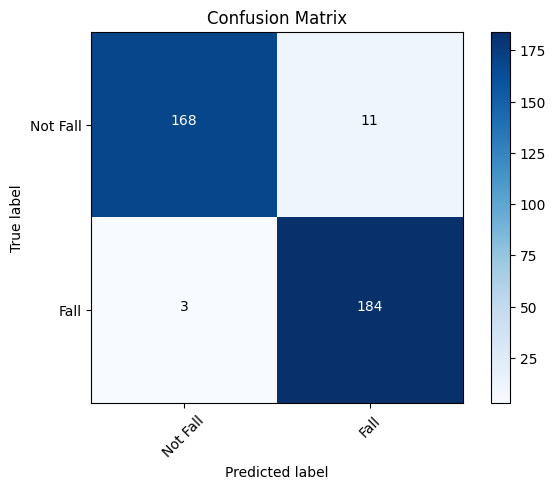

In [14]:
# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(model.predict(X_test), axis=-1)


# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)
# f1 score
precision_fp = cm[1][1] / (cm[1][1] + cm[0][1])
recall_fp = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score_fp = 2 * precision_fp * recall_fp / (precision_fp + recall_fp)
print('f1_score: ', f1_score_fp)


# Save Model

In [15]:
model.save('./saved_models/'+model_name+'.keras')
# convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if model_name=="ConvLSTM" or model_name=="ConvLSTM_VGG":
    converter._experimental_lower_tensor_list_ops = False
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
model_tflite = converter.convert()
# save the model
open('./saved_models/'+model_name+'.tflite', "wb").write(model_tflite)

INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpd44s2jfw\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpd44s2jfw\assets


139024

# Quantization

In [16]:
# only for ConvLSTM model
if model_name=="ConvLSTM" or model_name=="ConvLSTM_VGG":
    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    converter.inference_input_type = tf.float32
    converter.inference_output_type = tf.int8

    tflite_q_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
    input_type = interpreter.get_input_details()[0]['dtype']
    print('input: ', input_type)
    output_type = interpreter.get_output_details()[0]['dtype']
    print('output: ', output_type)
    # Save the quantized model to disk
    open('./saved_models/'+model_name+'_q.tflite', "wb").write(tflite_q_model)

In [17]:
q_model = tfmot.quantization.keras.quantize_model(model)
q_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_model.summary()

Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 6)]              0         []                            
                                                                                                  
 quantize_layer (QuantizeLa  (None, 50, 6)                3         ['input_2[0][0]']             
 yer)                                                                                             
                                                                                                  
 quant_reshape_1 (QuantizeW  (None, 1, 50, 6)             1         ['quantize_layer[0][0]']      
 rapperV2)                                                                                        
                                                                                        

In [18]:
q_model.save('./saved_models/'+model_name+'_q.keras')
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
if model_name == "TinyFallNet_6axis_8bitInput":
  print('model name: ', model_name)
  converter.inference_input_type = tf.int8  # Keep input as int8 for TinyFallNet_6axis_8bitInput
else:
  converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8 # Convert output to int8

# Convert the model
tflite_q_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open('./saved_models/'+model_name+'_q.tflite', "wb").write(tflite_q_model)

model name:  TinyFallNet_6axis_8bitInput
INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpe2_5q8ya\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpe2_5q8ya\assets
g:\python\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


68752

# QAT

In [19]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)

if model_name == "TinyFallNet_6axis_8bitInput":
    assert X_train.dtype == np.int8
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

q_history = q_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

y_train.shape:  (48633, 2)
y_val.shape:  (12159, 2)
Epoch 1/50
760/760 [==============================] - 20s 18ms/step - loss: 0.2142 - accuracy: 0.9574 - val_loss: 0.0598 - val_accuracy: 0.9783 - lr: 5.0000e-04
Epoch 2/50
760/760 [==============================] - 13s 18ms/step - loss: 0.1515 - accuracy: 0.9693 - val_loss: 0.0680 - val_accuracy: 0.9773 - lr: 5.0000e-04
Epoch 3/50
760/760 [==============================] - 13s 17ms/step - loss: 0.1653 - accuracy: 0.9727 - val_loss: 0.2976 - val_accuracy: 0.9196 - lr: 5.0000e-04
Epoch 4/50
760/760 [==============================] - 13s 17ms/step - loss: 0.1939 - accuracy: 0.9638 - val_loss: 0.1145 - val_accuracy: 0.9636 - lr: 5.0000e-04
Epoch 5/50
760/760 [==============================] - 13s 17ms/step - loss: 0.1584 - accuracy: 0.9691 - val_loss: 0.0821 - val_accuracy: 0.9738 - lr: 5.0000e-04
Epoch 6/50
758/760 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9731
Epoch 6: ReduceLROnPlateau reducing learning ra

In [20]:
q_model.save('./saved_models/'+model_name+'_qat.keras')  # The file needs to end with the .keras extension
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
if model_name == "TinyFallNet_6axis_8bitInput":
  converter.inference_input_type = tf.int8  # Keep input as int8 for TinyFallNet_6axis_8bitInput
else:
  converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_q_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open('./saved_models/'+model_name+'_qat.tflite', "wb").write(tflite_q_model)

INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpagncmga2\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpagncmga2\assets
g:\python\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


68976

model name:  TinyFallNet_6axis_8bitInput
input:  {'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 50,  6]), 'shape_signature': array([-1, 50,  6]), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'StatefulPartitionedCall:0', 'index': 73, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Evaluated on  0 .
Evaluated on  100 .
Evaluated on  200 .
Evaluated on  300 .
[[175   4]
 [  7 180]]
Confusion matrix, without normalization
[[175   4]
 [  7 180]]
f1_score:  0.9703504043126685


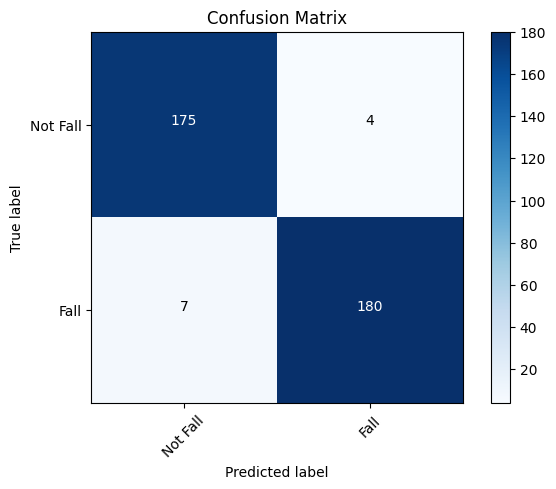

In [21]:
# test the quantized model
if model_name == "TinyFallNet_6axis_8bitInput":
    print('model name: ', model_name)
    X_test_qat = X_test.astype('int8')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.int8 and y_test_qat.dtype == np.int8
else:
    X_test_qat = X_test.astype('float32')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.float32 and y_test_qat.dtype == np.int8

# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= tflite_q_model)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_qat):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_qat, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
#accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
#print('accuracy: ', accuracy_fp)

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)


# Prune

In [22]:
# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

ups = pruning_callbacks.UpdatePruningStep()
# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()

Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 6)]              0         []                            
                                                                                                  
 prune_low_magnitude_reshap  (None, 1, 50, 6)             1         ['input_2[0][0]']             
 e_1 (PruneLowMagnitude)                                                                          
                                                                                                  
 prune_low_magnitude_conv2d  (None, 1, 48, 64)            2370      ['prune_low_magnitude_reshape_
 _1 (PruneLowMagnitude)                                             1[0][0]']                     
                                                                                        

In [23]:
pruned_model_unstructured.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, ups],
            class_weight=class_weight) 

Epoch 1/50
760/760 [==============================] - 21s 14ms/step - loss: 0.1616 - accuracy: 0.9679 - val_loss: 0.1284 - val_accuracy: 0.9590 - lr: 5.0000e-04
Epoch 2/50
760/760 [==============================] - 10s 13ms/step - loss: 0.1730 - accuracy: 0.9664 - val_loss: 0.0830 - val_accuracy: 0.9734 - lr: 5.0000e-04
Epoch 3/50
760/760 [==============================] - 10s 13ms/step - loss: 0.2086 - accuracy: 0.9598 - val_loss: 0.1412 - val_accuracy: 0.9527 - lr: 5.0000e-04
Epoch 4/50
760/760 [==============================] - 10s 13ms/step - loss: 0.1438 - accuracy: 0.9665 - val_loss: 0.1242 - val_accuracy: 0.9621 - lr: 5.0000e-04
Epoch 5/50
760/760 [==============================] - 10s 13ms/step - loss: 0.1258 - accuracy: 0.9724 - val_loss: 0.1341 - val_accuracy: 0.9561 - lr: 5.0000e-04
Epoch 6/50
760/760 [==============================] - 10s 13ms/step - loss: 0.1061 - accuracy: 0.9752 - val_loss: 0.0593 - val_accuracy: 0.9814 - lr: 5.0000e-04
Epoch 7/50
760/760 [==============

In [24]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(X_test, y_test, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', accuracy_fp)

Pruned model loss:  0.11663836240768433
Pruned model accuracy:  0.9699453711509705
Full-precision model accuracy:  0.9617486338797814


In [25]:
# save the model
pruned_model_unstructured.save('./saved_models/'+model_name+'_pruned_unstructured.keras')  # The file needs to end with the .keras extension
#print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = './saved_models/'+model_name+'_pruned_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

# print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))

INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpapbx7prm\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpapbx7prm\assets


In [26]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size('./saved_models/'+model_name+'_pruned_unstructured.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('./saved_models/'+model_name+'.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('./saved_models/'+model_name+'.tflite') / get_gzipped_model_size('./saved_models/'+model_name+'_pruned_unstructured.tflite')))

Size of the unstructured pruned model:  76904
Size of the full-precision model:  120275
The achieved compression ratio is 1.56x


# PQAT

In [27]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

pruned_qat_model.summary()

Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 6)]              0         []                            
                                                                                                  
 quantize_layer_1 (Quantize  (None, 50, 6)                3         ['input_2[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape_1 (QuantizeW  (None, 1, 50, 6)             1         ['quantize_layer_1[0][0]']    
 rapperV2)                                                                                        
                                                                                        

In [28]:
print('X_train.shape: ', X_train.shape) # (16362, 50, 9)
print('y_train.shape: ', y_train.shape) # (16362, 2)
if model_name == "TinyFallNet_6axis_8bitInput":
    assert X_train.dtype == np.int8
print(batch_size)
pruned_qat_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

X_train.shape:  (48633, 50, 6)
y_train.shape:  (48633, 2)
64
Epoch 1/50


760/760 [==============================] - 19s 17ms/step - loss: 0.4595 - accuracy: 0.9695 - val_loss: 0.0641 - val_accuracy: 0.9824 - lr: 5.0000e-04
Epoch 2/50
760/760 [==============================] - 12s 16ms/step - loss: 0.0498 - accuracy: 0.9898 - val_loss: 0.0405 - val_accuracy: 0.9888 - lr: 5.0000e-04
Epoch 3/50
760/760 [==============================] - 13s 16ms/step - loss: 0.0466 - accuracy: 0.9899 - val_loss: 0.0462 - val_accuracy: 0.9877 - lr: 5.0000e-04
Epoch 4/50
760/760 [==============================] - 12s 16ms/step - loss: 0.0304 - accuracy: 0.9937 - val_loss: 0.0316 - val_accuracy: 0.9911 - lr: 5.0000e-04
Epoch 5/50
760/760 [==============================] - 12s 16ms/step - loss: 0.0322 - accuracy: 0.9937 - val_loss: 0.0700 - val_accuracy: 0.9863 - lr: 5.0000e-04
Epoch 6/50
760/760 [==============================] - 13s 17ms/step - loss: 0.0527 - accuracy: 0.9904 - val_loss: 0.0864 - val_accuracy: 0.9802 - lr: 5.0000e-04
Epoch 7/50
760/760 [=========================

In [31]:
pruned_qat_model.save('./saved_models/'+model_name+'_pqat.keras')  # The file needs to end with the .keras extension
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
if model_name == "TinyFallNet_6axis_8bitInput":
  converter.inference_input_type = tf.int8  # Keep input as int8 for TinyFallNet_6axis_8bitInput
else:
  converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32
pruned_qat_tflite_model = converter.convert()

# Save the model
open('./saved_models/'+model_name+'_pqat.tflite', "wb").write(pruned_qat_tflite_model)

INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpafuqayu5\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpafuqayu5\assets
g:\python\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


69232

model name:  TinyFallNet_6axis_8bitInput
input:  {'name': 'TinyFallNet/quantize_layer_1/AllValuesQuantize/FakeQuantWithMinMaxVars;TinyFallNet/quantize_layer_1/AllValuesQuantize/FakeQuantWithMinMaxVars/ReadVariableOp;TinyFallNet/quantize_layer_1/AllValuesQuantize/FakeQuantWithMinMaxVars/ReadVariableOp_1', 'index': 24, 'shape': array([ 1, 50,  6]), 'shape_signature': array([-1, 50,  6]), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'TinyFallNet/quant_dense/Softmax', 'index': 73, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Evaluated on  0 .
Evaluated on  100 .
Evaluated on  200 

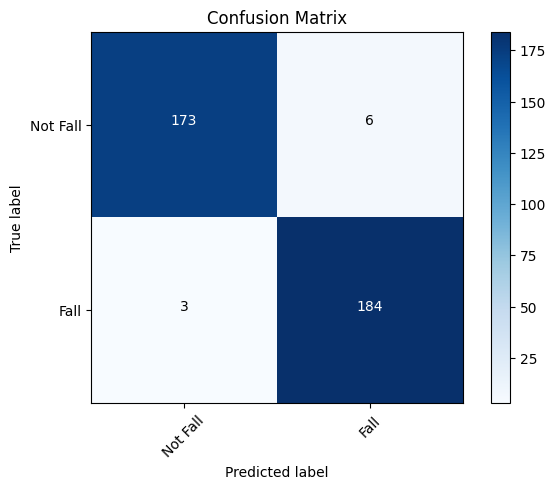

In [32]:
# test the quantized model
if model_name == "TinyFallNet_6axis_8bitInput":
    print('model name: ', model_name)
    X_test_qat = X_test.astype('int8')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.int8 and y_test_qat.dtype == np.int8
else:
    X_test_qat = X_test.astype('float32')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.float32 and y_test_qat.dtype == np.int8

# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= pruned_qat_tflite_model)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_qat):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_qat, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)

In [33]:
# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size('./saved_models/'+model_name+'_pqat.tflite'))
print('Size of th QAT model: ', get_gzipped_model_size('./saved_models/'+model_name+'_qat.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('./saved_models/'+model_name+'.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('saved_models/'+ model_name+ '.tflite') / get_gzipped_model_size('./saved_models/'+model_name+'_pqat.tflite')))

Size of the pruned QAT model:  33197
Size of th QAT model:  42333
Size of the full-precision model:  120275
The achieved compression ratio is 3.62x
